# DAML 09 - Image Features

Michal Grochmal <michal.grochmal@city.ac.uk>

Feature extraction is likely the most important, time consuming and nerve eating
activity in a machine learning pipeline.
Given enough data (millions of samples) we can perform feature extraction automatically,
yet that isn't viable in most cases.
For different types of data specialized feature extraction techniques exist.
Images probably have the most extensive number of feature building techniques.

Working with images we have been using pixel values as input to our models.
That is one way of doing things but it isn't the most effective way in practice.
Years of computer vision research did produce techniques for feature extraction
that easily outperform any form of PCA or fold learning.

In the Python world the `scikit-image` is the framework for image manipulation using `NumPy` arrays.  
And it is integrated with `matplotlib` too, we import these things fro now.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-talk')

`scikit-image`, imported as `skimage`, has several test images, all are just `NumPy` arrays.

In [2]:
from skimage import data
camera = data.camera()
camera.shape

(512, 512)

A two dimensional `NumPy` array is a gray-scale image.

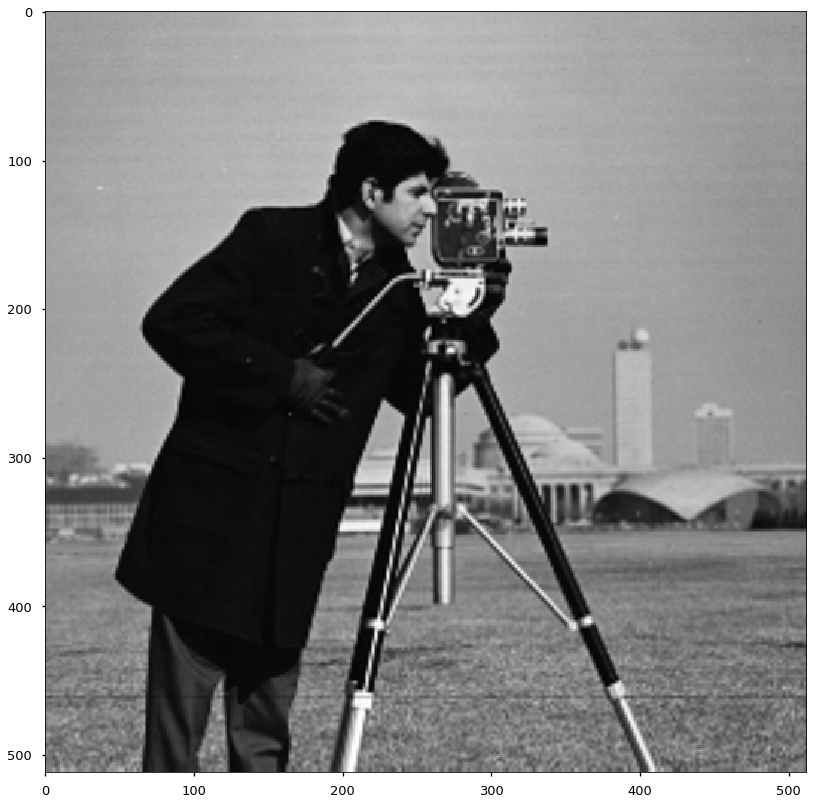

In [3]:
fit, ax = plt.subplots(figsize=(14, 14))
ax.imshow(camera, cmap='binary_r');

A color image is a three dimensional image where the last (rightmost)
dimension are the color channels (most often but not always RGB).
`skimage` tries to build standards for image representations as arrays,
their standards are:

| image                      | coordinates                   |
|:-------------------------- |:----------------------------- |
| 2D gray-scale              | (row, column)                 |
| 2D color image             | (row, column, channel)        |
| 3D gray-scale (e.g. video) | (frame, row, column)          |
| 3D color (e.g. video)      | (frame, row, column, channel) |

(400, 600, 3)

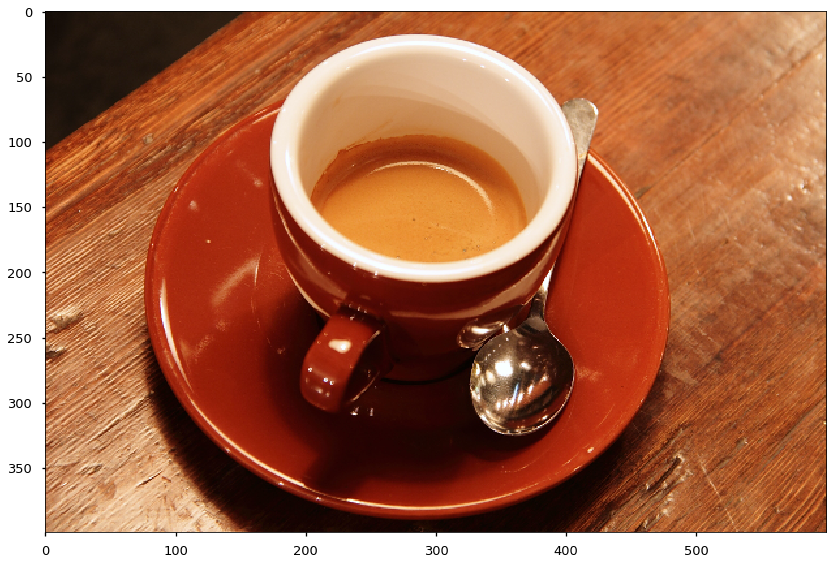

In [4]:
fit, ax = plt.subplots(figsize=(14, 14))
coffee = data.coffee()
ax.imshow(coffee);
coffee.shape

To be fair, videos are complicated to load into `NumPy` arrays.
This is mostly due to inter-frame compression in several video formats.
Tools, such as `moviepy` or `imageio`, can deal with several video formats
but if one can simply dismantle the video into a directory of frames it often produces better results.

Images can be read directly into `NumPy` arrays with `skimage`.
Most formats are supported, with a couple of special procedures to load TIFF and GIF files.

In [5]:
from skimage import io
tulp = io.imread('../data/rembrandt-tulp.png')

Again, this is just a `NumPy` array, therefore we can plot it.

(480, 624, 3)

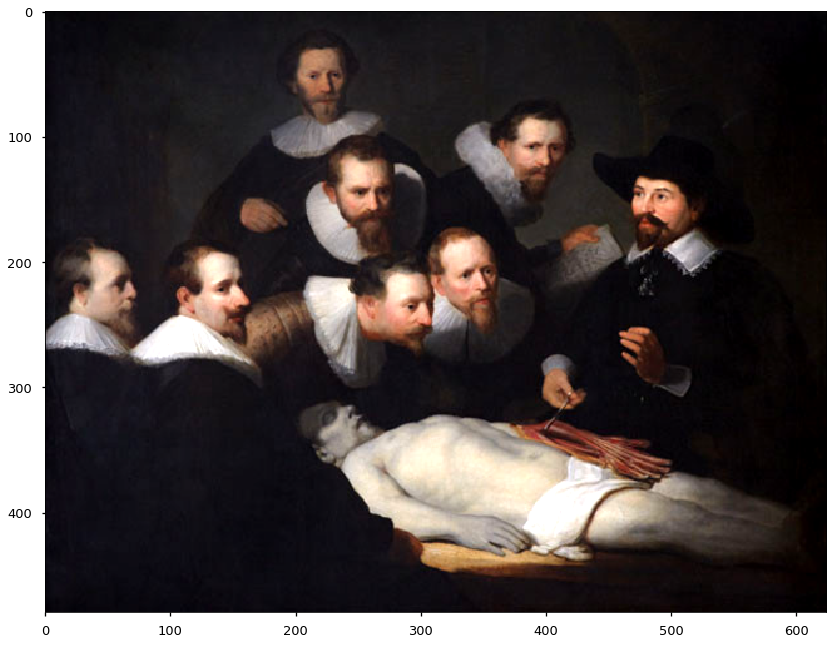

In [6]:
fit, ax = plt.subplots(figsize=(14, 14))
ax.imshow(tulp)
tulp.shape

You may have noticed that the $y$ coordinate of the displayed images is going from top to bottom.
This is the common representation in images, despite being different from a Cartesian graph.
The `NumPy` array we did just read is ordered in the way the axes above show.

We said that the last dimension of the array are the channels,
therefore separating the RGB channels is easy.

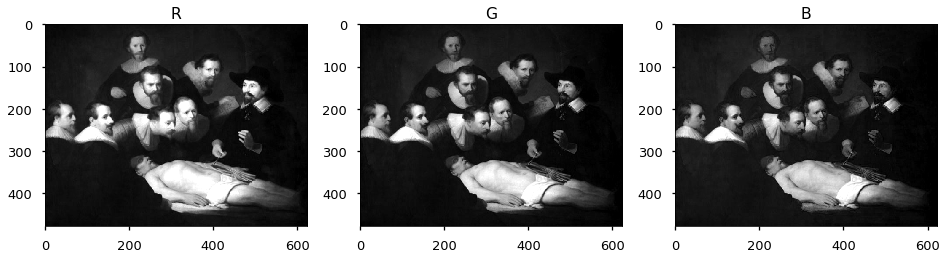

In [7]:
fit, ax = plt.subplots(1, 3, figsize=(16, 6))
component = ['R', 'G', 'B']
for i in range(3):
    ax.flat[i].imshow(tulp[:, :, i], cmap='binary_r')
    ax.flat[i].set_title(component[i])

But RGB channels are device specific,
and, therefore, very poor for image features.

Instead, other representations such a s HSV or LAB are both:
device independent and close to how a human sees an image.

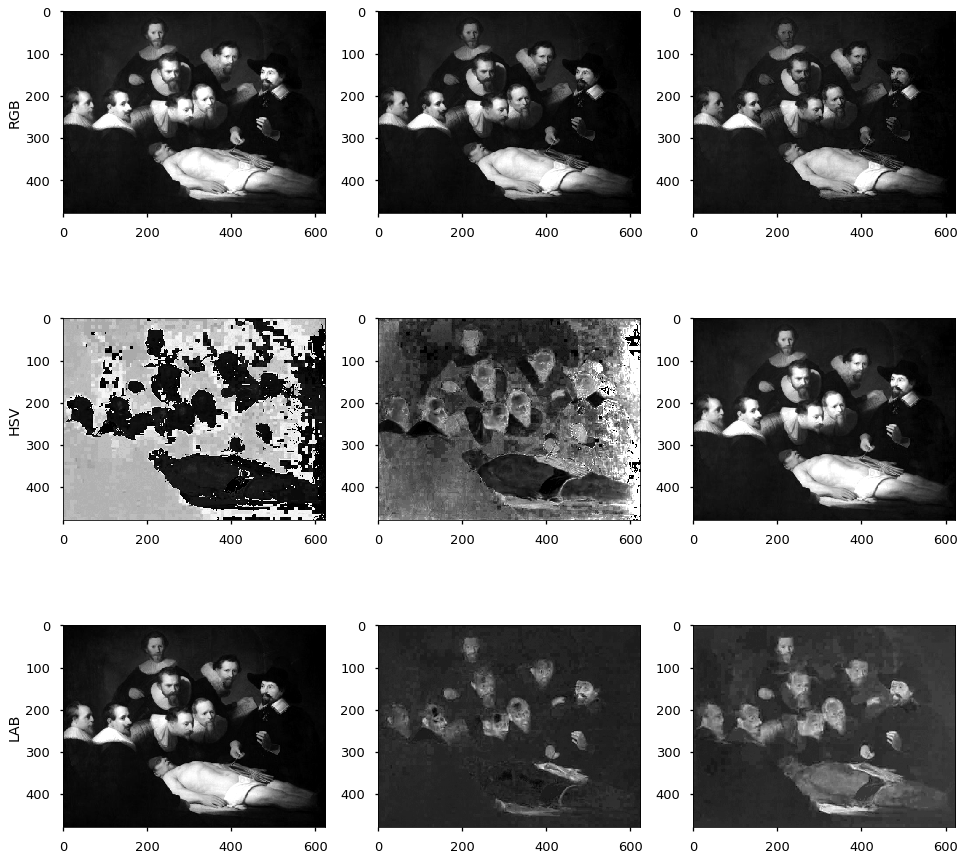

In [8]:
from skimage import color
tulp_hsv = color.rgb2hsv(tulp)
tulp_lab = color.rgb2lab(tulp)
fit, ax = plt.subplots(3, 3, figsize=(16, 16))
tulp_arr = [tulp, tulp_hsv, tulp_lab]
repr_arr = ['RGB', 'HSV', 'LAB']
for i in range(3):
    for j in range(3):
        ax[i, j].imshow(tulp_arr[i][:, :, j], cmap='binary_r')
        if not j:
            ax[i, j].set_ylabel(repr_arr[i])

The $V$ in HSV and the $L$ in LAB representations are actually
the transformation we perform when we convert an image to gray-scale.
On a decent piece of software that is,
bad software often does $R/3 + G/3 +B/3$.

`skimage.feature` then has several features that make sense on the lightness ($L$) of an image.
The Canny filter is a feature that describes where the image changes the most.
It is a *kernel* that walks the image and differentiates between adjacent pixels.
High derivatives are then set to one and low ones to zero.

This kernel method is called a function *convolution*.

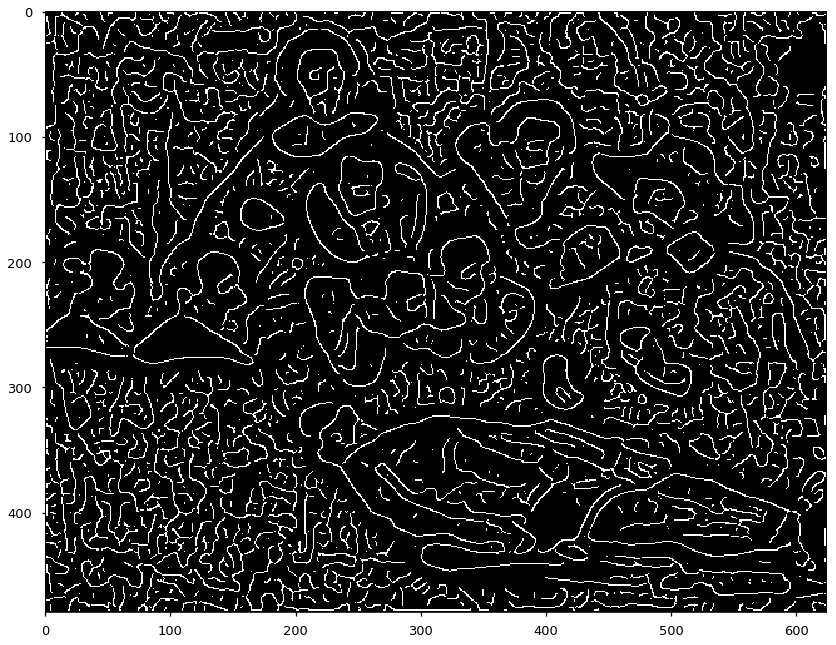

In [9]:
from skimage import feature
canny = feature.canny(tulp_lab[:, :, 0], sigma=3)
fit, ax = plt.subplots(figsize=(14, 14))
ax.imshow(canny, cmap='binary_r');

The Sobel filter is similar to the Canny filter
but it keeps the scaled values of all derivatives instead of forcing them to zero and one.
Contrary to the Canny filter, Sobel does not have a parameter for image scaling
therefore we need to do it ourselves.

The LAB representation uses floating point numbers,
which is acceptable for `skimage` algorithms.
Yet `skimage` expects floating points representations to be scaled between
-1 and 1 or between 0 and 1.
We scale the lightness channel between 0 and 1.

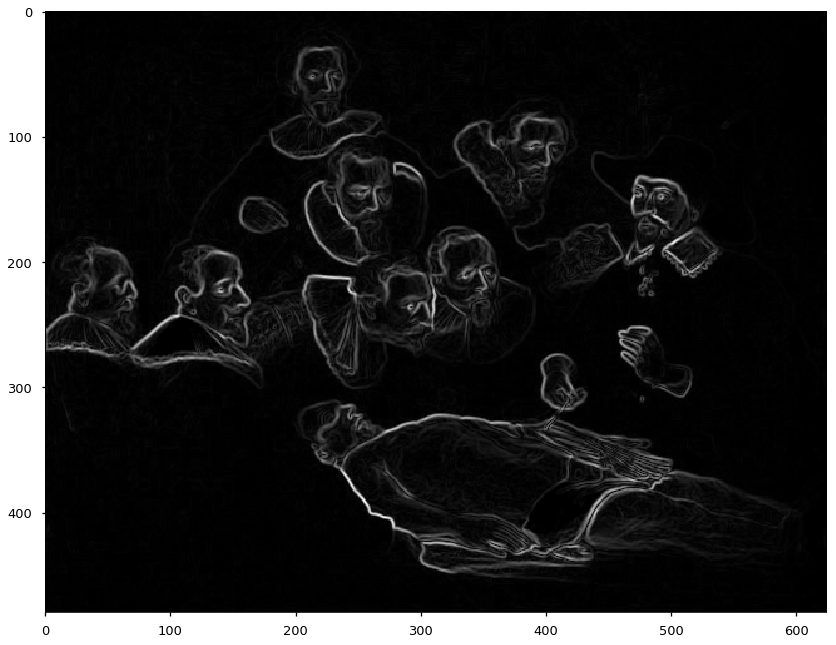

In [10]:
from skimage import filters
sobel = filters.sobel(tulp_lab[:, :, 0]/tulp_lab[:, :, 0].max())
fit, ax = plt.subplots(figsize=(14,14))
ax.imshow(sobel, cmap='binary_r');

The painting we are using is actually a rather difficult image to work with:
there are very few colors and the light comes from the middle of the picture.
As an exercise we will try to segment the image into relevant parts.
Most [segmentation techniques][scomp] use color but that is inviable for this one,
instead we will use watershed segmentation which uses the same derivatives
as the Canny and Soble filters.

[segmt]: http://scikit-image.org/docs/dev/api/skimage.segmentation.html#skimage.segmentation.watershed
[scomp]: http://scikit-image.org/docs/dev/auto_examples/segmentation/plot_segmentations.html

[Watershed segmentation][segmt] attempts to join areas defined by high derivatives
by bleeding between the areas.
First we blur the image in several disks of diameter of 7 pixels,
next we take all gradients (partial derivatives) across the resulting image.
We will assume that where the gradients are small we have a continuous area,
and where we have high gradients we separate areas.
The we use [scipy.ndimage.label][label] to enumerate the areas in the mask we created.
Finally we feed the enumerated areas to the watershed algorithm.

[label]: https://docs.scipy.org/doc/scipy-1.1.0/reference/generated/scipy.ndimage.label.html

Since we are just working with `NumPy` arrays we can do it all with a couple of array operations.
Note: the `skimage` documentation warns against using `astype` to convert between float
and integer based images, yet what we perform here is the exact implementation of `skimage`'s
`img_as_ubyte` procedure.

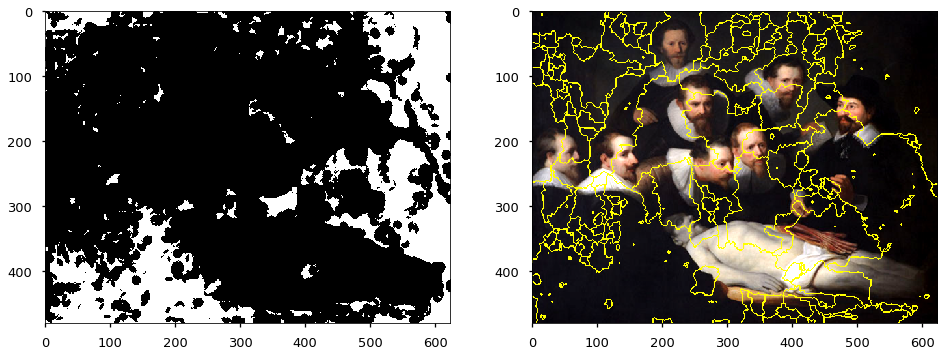

In [11]:
from skimage import segmentation, morphology
from scipy.ndimage import label
tulp_float = tulp_lab[:, :, 0] / tulp_lab[:, :, 0].max()
tulp_int = (tulp_float * 255).astype(np.uint8)
small_gradients = filters.rank.gradient(tulp_int, morphology.disk(7)) < 6
labeled, num_features = label(small_gradients)
water = segmentation.watershed(tulp_lab[:, :, 0], markers=labeled)
fit, ax = plt.subplots(1, 2, figsize=(16, 6))
ax.flat[0].imshow(small_gradients, cmap='binary_r')
ax.flat[1].imshow(segmentation.mark_boundaries(tulp, water));

We have lost of small areas.
We could tweak the size of the disk or the value of the minimal gradient to remove them,
yet that would impact the borders of the big areas.
Let's see how the areas are represented.

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104,
       105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117,
       118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130,
       131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143,
       144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156,
       157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169,
       170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 18

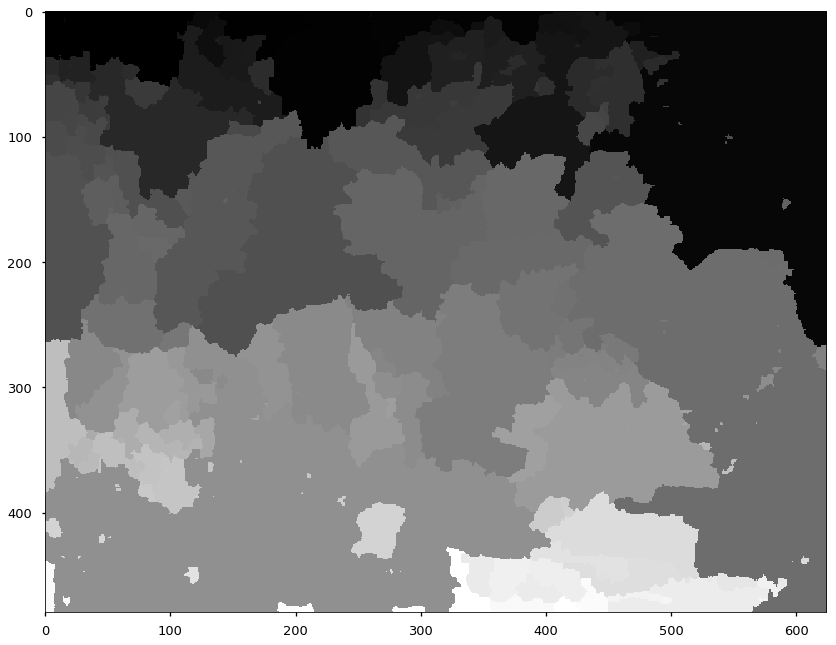

In [12]:
fit, ax = plt.subplots(figsize=(14, 14))
ax.imshow(water, cmap='binary_r')
np.unique(water)

Since we are simply dealing with a `NumPy` array,
we can join the areas smaller than 512 pixels in tot total into the biggest area.
This should remove several of the small areas.

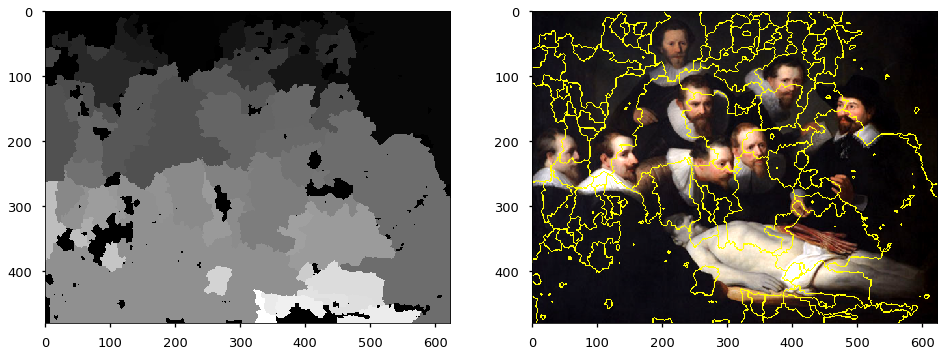

In [13]:
for i in np.unique(water):
    if (water == i).sum() < 512:
        water[water == i] = 1
fit, ax = plt.subplots(1, 2, figsize=(16, 6))
ax.flat[0].imshow(water, cmap='binary_r')
ax.flat[1].imshow(segmentation.mark_boundaries(tulp, water));

Finally, we can mask using `NumPy` arrays.
Therefore we can retrieve each of the areas as a separate image.
A separate image can then be fed again into feature extraction,
and a set of sub-images can be added as features.
For example, to retrieve one of the watershed areas.

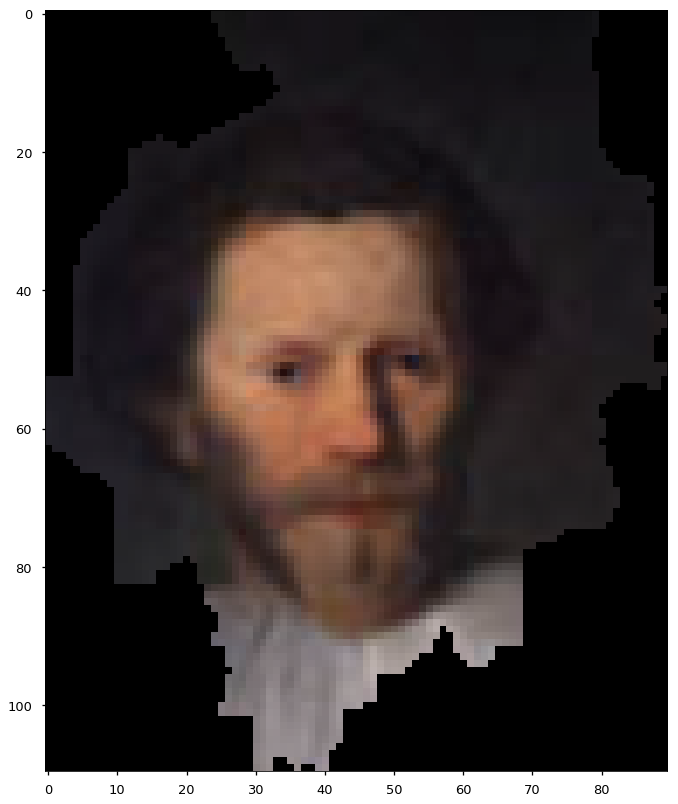

In [14]:
fit, ax = plt.subplots(figsize=(14, 14))
area = tulp.copy()
mask = np.zeros_like(tulp[:, :, 0])
area_n = 4
for channel in range(3):
    chan = area[:, :, channel]
    chan[~(water == area_n)] = 0
mask[water == area_n] = 1
rows = mask.sum(axis=1) > 0
columns = mask.sum(axis=0) > 0
ax.imshow(area[rows, :, :][:, columns, :]);

## References

- [SciKit Image Documentation][1]
- [The image used is Rembrandt's "Anatomy Lesson of Dr Tulp" - Image from the VADS' NIRP Project][2]

[1]: http://scikit-image.org/docs/stable/index.html "SciKit Image"
[2]: https://vads.ac.uk/collections/NIRP/index.php "VADS - NIRP"